# AI Underwriter Assistants

Assembling an A-team of AI underwriter assistants 🚀

Author: https://github.com/deburky

In [1]:
import os
import openai
from dotenv import load_dotenv

load_dotenv()

openai_key = os.getenv('OPENAI_API_KEY')

In [2]:
# Fetch loan approval data
import pyarrow as pa
from pyarrow import csv
import pyarrow.parquet as pq
import requests
import pandas as pd
from io import BytesIO

# Define URL and fetch data
url = "https://drive.google.com/file/d/1r6gGvL_s313ThGSU7ziZiuYr2G_yijaZ/view?usp=sharing"
file_id = url.split("/")[-2]
response = requests.get(f"https://drive.google.com/uc?id={file_id}")

# Load CSV data into memory buffer
csv_buffer = BytesIO(response.content)

# Read entire dataset
full_data = csv.read_csv(csv_buffer).to_pandas()

# Split into train and test
train_set = full_data.query("Credit_History.notna()").sample(700, random_state=42).reset_index(drop=True)
test_set = full_data.query("Credit_History.isnull()").sample(100, random_state=42).reset_index(drop=True)

# Drop sensitive attribute
train_set = train_set.drop(columns=["Gender"])
test_set_with_labels = test_set.copy()
test_set = test_set.drop(columns=["Gender", "Loan_Status"])

print(train_set.shape, test_set.shape)

# Convert to PyArrow tables
train_table = pa.Table.from_pandas(train_set)
test_table = pa.Table.from_pandas(test_set)

# Write to Parquet
pq.write_table(train_table, "../data/loans-9309cbc146a4.parquet")
pq.write_table(test_table, "../data/loans-new-9309cbc146a4.parquet")

# Display sample data
display(train_set.sample(5), test_set.sample(5))

(700, 12) (100, 11)


,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
611,LP001581,No,0,Graduate,nan,3418,2083.0,120.0,360.0,1.0,Rural,Y
158,LP002588,Yes,1,Not Graduate,Yes,2653,1500.0,113.0,360.0,1.0,Urban,Y
399,LP001754,No,0,Graduate,Yes,2479,0.0,70.0,360.0,1.0,Rural,Y
231,LP002347,Yes,0,Graduate,Yes,5829,0.0,144.0,360.0,1.0,Rural,Y
377,LP001546,Yes,0,Graduate,Yes,2383,2138.0,74.0,360.0,1.0,Urban,Y


,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
76,LP002720,Yes,1,Not Graduate,Yes,5285,1430.0,186.0,360.0,NaN,Semiurban
14,LP001870,No,0,Graduate,No,7451,0.0,175.0,360.0,NaN,Rural
25,LP002585,Yes,0,Graduate,Yes,3597,3300.0,173.0,360.0,NaN,Rural
44,LP002229,Yes,0,Graduate,nan,3333,0.0,70.0,360.0,NaN,Semiurban
49,LP002502,No,0,Graduate,No,7451,0.0,140.0,360.0,NaN,Semiurban


## Train a scoring model

We train an ML scoring model to predict credit score.

In [3]:
import catboost as cb
from sklearn.compose import make_column_selector 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=1,
    l2_leaf_reg=3,
    loss_function='Logloss',
    verbose=False,
    allow_writing_files=False,
    random_seed=0
)

X = train_set.drop(columns=['Loan_Status', 'Loan_ID'])
y = train_set['Loan_Status']

column_selector = make_column_selector(dtype_include=['object'])
cat_features = column_selector(X)
model.set_params(cat_features=cat_features)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

model.fit(X_train, y_train)

def gini_score(roc_auc_score):
    """Compute Gini from ROC AUC."""
    return 2 * roc_auc_score - 1

train_gini = gini_score(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
val_gini = gini_score(roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]))

print(f"Train Gini: {train_gini:.4f}")
print(f"Validation Gini: {val_gini:.4f}")

Train Gini: 0.6358
Validation Gini: 0.5606


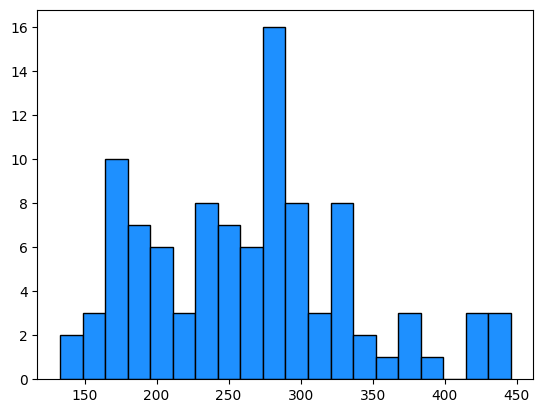

In [4]:
from scipy.special import logit

features = list(X.columns)

test_set['Score'] = model.predict_proba(test_set[features])[:, 0]
test_set['Credit_Score'] = -test_set['Score'].apply(lambda x: 0 + 350 * logit(x - 0.5)).round(0)
test_set['Credit_Score'].hist(bins=20, edgecolor='black', color='dodgerblue', grid=False)

test_set.drop(columns=['Score'], inplace=True)

scores_table = pa.Table.from_pandas(test_set)
pq.write_table(scores_table, "../data/scores-new-9309cbc146a4.parquet")

In [5]:
test_set

,Loan_ID,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Credit_Score
0,LP001028,Yes,0,Graduate,Yes,5726,2142.0,184.0,360.0,NaN,Rural,200.0
1,LP002585,Yes,0,Graduate,Yes,4625,3300.0,111.0,12.0,NaN,Urban,241.0
2,LP002821,Yes,0,Not Graduate,No,18165,1000.0,600.0,360.0,NaN,Semiurban,276.0
3,LP001770,Yes,1,Graduate,Yes,5500,4250.0,170.0,360.0,NaN,Rural,159.0
4,LP002224,Yes,0,Graduate,Yes,4817,0.0,100.0,360.0,NaN,Semiurban,281.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,LP001750,Yes,1,Graduate,Yes,6250,1695.0,210.0,360.0,NaN,Rural,191.0
96,LP002789,Yes,0,Graduate,Yes,5923,3906.0,184.0,360.0,NaN,Urban,203.0
97,LP002225,Yes,0,Graduate,Yes,4310,0.0,100.0,360.0,NaN,Semiurban,281.0
98,LP002706,Yes,1,Not Graduate,Yes,5285,1131.0,161.0,360.0,NaN,Semiurban,298.0


## Underwriting with Assistants

[OpenAI - Assistants API quickstart](https://platform.openai.com/docs/assistants/quickstart)

[Fun with Assistants – getting them to really talk to each other](https://community.openai.com/t/fun-with-assistants-getting-them-to-really-talk-to-each-other/784073/12)

In [6]:
import time
import pyarrow.parquet as pq
from io import BytesIO
from openai import OpenAI
from rich.console import Console
from rich.live import Live
from rich.table import Table

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from src.utils import (
    pyarrow_to_csv_buffer,
    fetch_messages,
    AssistantRunner,
)

# Initialize OpenAI client and console
client = OpenAI()
runner = AssistantRunner(client)
console = Console(highlight=False)


# Load data
train_table = pq.read_table("../data/loans-9309cbc146a4.parquet")
test_table = pq.read_table("../data/loans-new-9309cbc146a4.parquet")
test_table_with_scores = pq.read_table("../data/scores-new-9309cbc146a4.parquet")

# Upload files
train_file = client.files.create(
    file=("train.csv", pyarrow_to_csv_buffer(train_table)), purpose="assistants"
)
test_file = client.files.create(
    file=("test.csv", pyarrow_to_csv_buffer(test_table)), purpose="assistants"
)

test_file_with_scores = client.files.create(
    file=("test_with_scores.csv", pyarrow_to_csv_buffer(test_table_with_scores)), purpose="assistants"
)

# Load instructions for underwriter
with open("../instructions/instructions_underwriter.txt", "rb") as f:
    instructions_underwriter = f.read().decode("utf-8")

# Create Assistants
underwriter = client.beta.assistants.create(
    name="AI Underwriter Assistant",
    description="Analyzes loan applications.",
    instructions=instructions_underwriter,
    model="gpt-4o",
    tools=[{"type": "code_interpreter"}],
    tool_resources={"code_interpreter": {"file_ids": [train_file.id, test_file.id]}},
)

# Load instructions for decision maker
with open("../instructions/instructions_decision_maker.txt", "rb") as f:
    instructions_decision_maker = f.read().decode("utf-8")

decision_maker = client.beta.assistants.create(
    name="AI Decision Maker",
    description="Decides loan approvals.",
    instructions=instructions_decision_maker,
    model="gpt-4o",
    tools=[{"type": "code_interpreter"}],
    tool_resources={"code_interpreter": {"file_ids": [test_file_with_scores.id]}},
)

# Create thread
thread = client.beta.threads.create()

# Run steps sequentially
steps = [
    (
        "📝 Step 1: Underwriter Introduction",
        underwriter.id,
        "Briefly introduce yourself and your underwriting approach.",
    ),
    (
        "📝 Step 2: Decision Maker Introduction",
        decision_maker.id,
        "Briefly introduce yourself and your decision-making approach.",
    ),
    (
        "📝 Step 3: Decision Maker Finalizes Approvals",
        decision_maker.id,
        "Review underwriting report and format your response as a structured CSV file with 'Loan_ID' and 'Loan_Status'",
    ),
]

# Run steps sequentially
with Live(console=console, refresh_per_second=1) as live:
    for step_name, assistant_id, instruction in steps:
        console.print(f"\n{step_name}", style="bold cyan")
        
        run = runner.start(assistant_id, thread.id, instruction)

        while True:
            table = fetch_messages(client, thread.id)
            live.update(table)
            run_status = client.beta.threads.runs.retrieve(
                thread_id=thread.id, run_id=run.id
            )
            if run_status.status in ["completed", "failed", "cancelled"]:
                break
            time.sleep(2)

console.print("\n[bold green]Underwriting workflow completed successfully![/bold green]")

# Set up record console
final_table = fetch_messages(client, thread.id)
record_console = Console(record=True)
record_console.print(final_table)

# Export recorded content to HTML
record_console.save_html("../report/underwriting_conversation.html")

📝 Step 1: Underwriter Introduction

Output()

📝 Step 2: Decision Maker Introduction

📝 Step 3: Decision Maker Finalizes Approvals

Underwriting workflow completed successfully!

                                        AI Underwriting Conversation (Live)                                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Role         ┃ Message                                                                                          ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user         │ Briefly introduce yourself and your underwriting approach.                                       │
│ assistant    │ I am an AI Underwriter, designed to assist in evaluating loan applications by analyzing          │
│              │ historical loan approval data. My primary focus is to identify patterns, trends, and risk        │
│              │ factors associated with loan approvals and rejections.                                           │
│              │                                                                                                  │
│              │ My underwriting approach involves the following steps:                                           │
│              │                                                                                                  │
│              │ 1. **Descriptive Analysis**: To get an overview and understanding of the dataset, identifying    │
│              │ key variables and their distributions.                                                           │
│              │                                                                                                  │
│              │ 2. **Correlation Analysis**: Identify features that have strong correlations with loan approval  │
│              │ statuses. This helps highlight factors that influence decision-making and applicant risk.        │
│              │                                                                                                  │
│              │ 3. **Insight Generation**: Distill meaningful insights that can guide underwriting decisions.    │
│              │ These might include factors that increase approval likelihood or potential red flags that could  │
│              │ lead to rejection.                                                                               │
│              │                                                                                                  │
│              │ 4. **Recommendations**: Provide actionable insights for decision-makers to consider, focusing on │
│              │ enhancing the approval process, mitigating risk, and ensuring consistency.                       │
│              │                                                                                                  │
│              │ Let's begin by examining the contents of the uploaded files to get a clearer picture of the data │
│              │ available to us.                                                                                 │
│ assistant    │ The dataset contains the following columns:                                                      │
│              │                                                                                                  │
│              │ 1. **Loan_ID**: Unique identifier for each loan application.                                     │
│              │ 2. **Married**: Marital status of the applicant.                                                 │
│              │ 3. **Dependents**: Number of dependents the applicant has.                                       │
│              │ 4. **Education**: Education level of the applicant (Graduate/Not Graduate).                      │
│              │ 5. **Self_Employed**: Whether the applicant is self-employed or not.                             │
│              │ 6. **ApplicantIncome**: Income of the applicant.                                                 │
│              │ 7. **CoapplicantIncome**: Income of the

## Save report

In [7]:
import pandas as pd
from openai import OpenAI

# Fetch the list of files
files = client.files.list()

# Extract filenames and file IDs
file_info = [(file.id, file.filename, file.purpose, file.status) for file in files.data]

# Convert to DataFrame for better readability
df_files = pd.DataFrame(file_info, columns=["File ID", "Filename", "Purpose", "Status"])

# # Display the extracted filenames
display(df_files)

,File ID,Filename,Purpose,Status
0,file-QXcnUmt4tDEUFcpsTLdKbS,/mnt/data/loan_status_decisions.csv,assistants_output,processed
1,file-KawYp3BQQX2tsx8xjrVGtK,test_with_scores.csv,assistants,processed
2,file-K3HUyaRzNgsZiF9YGEYWu2,test.csv,assistants,processed
3,file-APgwGMHY47GVDJ88m5Rnzc,train.csv,assistants,processed


In [8]:
import io
evaluation_results = df_files.iloc[0]['File ID'] # Fetch assistants_output
content = client.files.retrieve_content(evaluation_results)
csv_string = content
csv_file = io.StringIO(csv_string)
df = pd.read_csv(csv_file)
print(df.shape, test_set_with_labels.shape)
print(df.head(5), test_set_with_labels[['Loan_ID', 'Loan_Status']].head(5))

/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_76411/1265948440.py:3: DeprecationWarning: The `.content()` method should be used instead
  content = client.files.retrieve_content(evaluation_results)


(100, 2) (100, 13)
    Loan_ID Loan_Status
0  LP001028           Y
1  LP002585           Y
2  LP002821           Y
3  LP001770           N
4  LP002224           Y     Loan_ID Loan_Status
0  LP001028           N
1  LP002585           Y
2  LP002821           N
3  LP001770           Y
4  LP002224           Y


In [9]:
df['Loan_Status'].value_counts(normalize=True)

Loan_Status
Y    0.78
N    0.22
Name: proportion, dtype: float64

## Evaluation against ground truth

In [10]:
testing_df = pd.DataFrame({
    'Loan_ID': test_set_with_labels['Loan_ID'].reset_index(drop=True),
    'Loan_Status_Assistant': df['Loan_Status'].reset_index(drop=True),
    'Loan_Status_Truth': test_set_with_labels['Loan_Status'].reset_index(drop=True)
})
testing_df.replace({'Y': 1, 'N': 0}, inplace=True)

print(testing_df.shape)

(100, 3)


/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_76411/1809122007.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  testing_df.replace({'Y': 1, 'N': 0}, inplace=True)


In [11]:
decision_matrix = pd.crosstab(
    testing_df['Loan_Status_Assistant'],
    testing_df['Loan_Status_Truth'],
    normalize='all'
)
display(decision_matrix)


display(testing_df['Loan_Status_Assistant'].value_counts(normalize=True))
display(testing_df['Loan_Status_Truth'].value_counts(normalize=True))

Loan_Status_Truth,0,1
Loan_Status_Assistant,,
0,0.06,0.16
1,0.15,0.63


Loan_Status_Assistant
1    0.78
0    0.22
Name: proportion, dtype: float64

Loan_Status_Truth
1    0.79
0    0.21
Name: proportion, dtype: float64

In [12]:
from src.utils import delete_all_assistants_and_files

# Run the cleanup function
delete_all_assistants_and_files()

🔍 Found 2 assistants to delete...
🗑️ Deleting Assistant: AI Decision Maker (ID: asst_uMwE6R0AHS3VhcDdwvkBPt2m)
🗑️ Deleting Assistant: AI Underwriter Assistant (ID: asst_RxNSfaNN5dsMC43rscNnpwbd)
✅ All assistants deleted!
🔍 Found 4 files to delete...
🗑️ Deleting File: /mnt/data/loan_status_decisions.csv (ID: file-QXcnUmt4tDEUFcpsTLdKbS)
🗑️ Deleting File: test_with_scores.csv (ID: file-KawYp3BQQX2tsx8xjrVGtK)
🗑️ Deleting File: test.csv (ID: file-K3HUyaRzNgsZiF9YGEYWu2)
🗑️ Deleting File: train.csv (ID: file-APgwGMHY47GVDJ88m5Rnzc)
✅ All files deleted!
